In [1]:
import numpy as np
from os.path import join
from skimage.io import imsave, imread
from skimage.transform import resize

## Backend Settings
from keras import backend as K
import tensorflow as tf
#tf.enable_eager_execution()
import matplotlib.pyplot as plt

import utils

Using TensorFlow backend.


In [2]:
imgs_train, imgs_train_masks = utils.load_train_data(join('..', 'data'))
target_shape = (128, 128)
print(imgs_train.shape, imgs_train_masks.shape)

(5635, 420, 580) (5635, 420, 580)


In [3]:
imgs_train_preprocessed = utils.preprocess_x(imgs_train, new_shape=target_shape)

Training Stats: mu=99.3280258178711, sigma=56.435367584228516


In [13]:
import model_build as mb
net = mb.load_model(join('..', 'models', 'Unet_v7'))

In [22]:
def back_to_origianl_shape(imgs, new_shape):
    imgs = imgs.reshape(imgs.shape[:-1])
    x_train = np.ndarray((imgs.shape[0], new_shape[0], new_shape[1]), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        x_train[i] = resize(imgs[i], new_shape, preserve_range=True)

    x_train = x_train[..., np.newaxis].astype('float32')
    return x_train

----
## Show images

In [20]:
preds = net.predict(imgs_train_preprocessed[:16], batch_size=16)

In [23]:
preds = back_to_origianl_shape(imgs=preds, 
                               new_shape=imgs_train_masks.shape[1:])

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [26]:
preds[1].shape

(420, 580, 1)

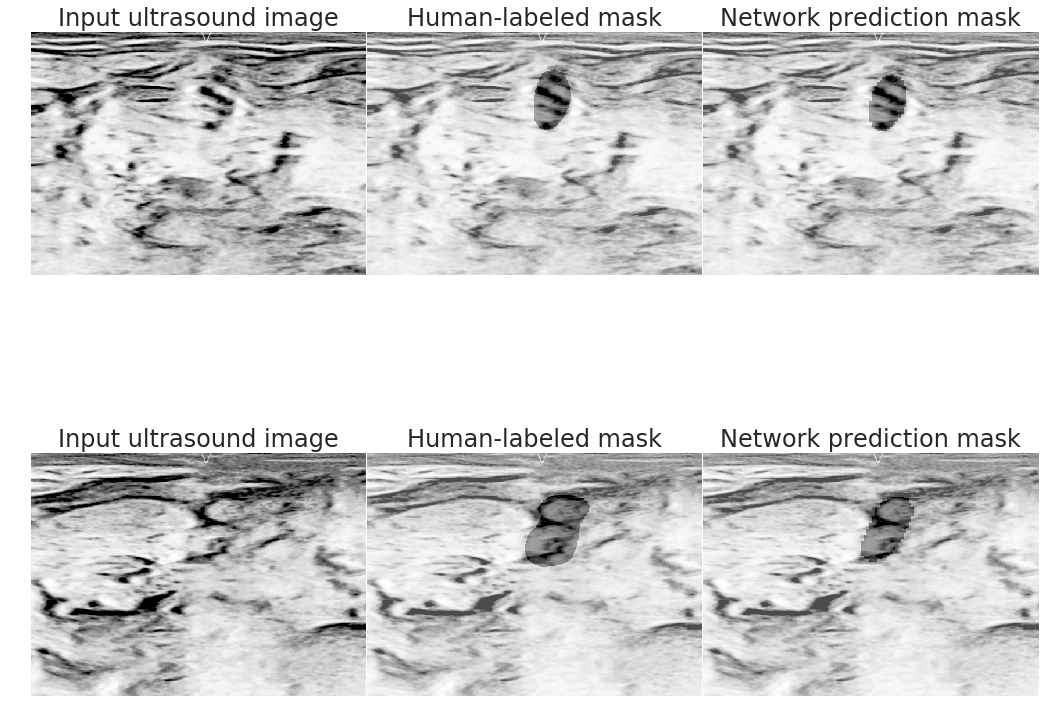

In [46]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(2, 3, figsize=(15,12))

for i in range(2):
    ax[i][0].imshow(imgs_train[i])
    ax[i][1].imshow(imgs_train[i])
    ax[i][1].imshow(imgs_train_masks[i], alpha=0.3)
    ax[i][2].imshow(imgs_train[i])
    ax[i][2].imshow(preds[i].reshape(imgs_train[i].shape), alpha=0.3)

    ax[i][0].set_title('Input ultrasound image', fontsize=24)
    ax[i][1].set_title('Human-labeled mask', fontsize=24)
    ax[i][2].set_title('Network prediction mask', fontsize=24)
    for j in range(3):
        ax[i][j].axis('off')
        ax[i][j].set_aspect('equal')
        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.style.use('seaborn-white')
plt.savefig('example.png', dpi=300)

---
## Model Conversion 
* See [KtoTF.py](./KtoTF.py)

In [2]:
### Load quantized model from KtoTF.py
with tf.gfile.GFile('../Unet_v7/Unet_v7.pb', "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

graph = tf.get_default_graph()
tf.import_graph_def(graph_def, name="Unet")

In [3]:
### From deepdream notebook
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
    
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph(graph_def)

In [6]:
from tfserve import helper
helper.estimate_io_tensors("../Unet_v7/Unet_v7.pb")

Possible INPUT tensors:
  name              shape             dtype
  import/input_1:0  (?, 128, 128, 1)  float32

Possible OUTPUT tensors:
  name                          shape             dtype
  import/conv2d_19_1/Sigmoid:0  (?, 128, 128, 1)  float32


---
* From keras .h5 file to tensorflow .pb
* From tensorflow .pb to tensorflow lite .tflite

In [21]:
# https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27
from keras.layers.core import K
from tensorflow.python.saved_model import builder as saved_model_builder
import model_build

target_shape = (96, 96)

# Build a model instance
K.set_learning_phase(0)
mbuilder = model_build.ModelBuilder(input_shape=target_shape, output_shape=target_shape)
model = mbuilder.build_model(kind='Unet')

export_path = '../Unet_v7_pb'

# Create a tf session and load pre-trained weights
# Add tag set for tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    model.load_weights('../models/Unet_v3/weights.h5')
    tf.saved_model.simple_save(
        sess,
        export_path,
        inputs={'input_image': model.input},
        outputs={t.name:t for t in model.outputs}
    )
    
converter = tf.contrib.lite.TocoConverter.from_saved_model('../Unet_v3_pb')
converter.post_training_quantize = True
tflite_quantized_model = converter.convert()

model_path = "quantized_model.tflite"
open(model_path, "wb").write(tflite_quantized_model)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../Unet_v3_pb/saved_model.pb


## Evaluation of quantized model

In [6]:
model_path = "quantized_model.tflite"

In [7]:
# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

In [8]:
interpreter.resize_tensor_input(input_details[0]['index'], imgs_train.shape)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], imgs_train)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
output_data.shape

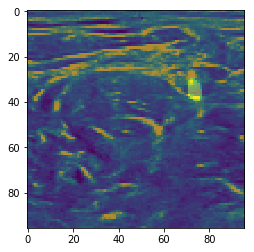

In [62]:
plt.imshow(imgs_train[i].reshape(target_shape))
plt.imshow(output_data.reshape(target_shape), alpha=0.4)

## Read deployed model response

In [157]:
import pickle
with open('./response.pkl', 'rb') as f:
    response = pickle.load(f)
    
output = response.json()

In [158]:
import numpy as np
pred = np.array(output['y'])
pred = pred.reshape((128,128))
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0
pred = pred.astype('uint8')

In [159]:
pred.shape

(128, 128)

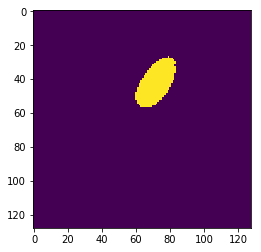

In [160]:
import matplotlib.pyplot as plt
plt.imshow(pred)

(128, 128)


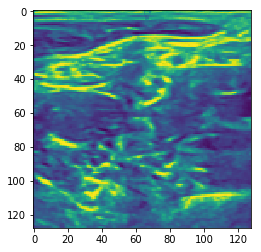

In [156]:
img = np.load('request_data.npy').reshape(target_shape)
print(img.shape)
plt.imshow(img)